# KPIs & Métricas: EDA y Modelado
Este notebook sigue una estructura típica para análisis exploratorio de datos (EDA) y modelado.

# Tabla de Contenido
- [1. Instalación y Librerías](#1-instalación-y-librerías)
- [2. Carga de Datos](#2-carga-de-datos)
- [3. Análisis Exploratorio de Datos (EDA)](#3-análisis-exploratorio-de-datos-eda)
- [4. Preprocesamiento de Datos](#4-preprocesamiento-de-datos)
- [5. Modelado](#5-modelado)
- [6. Interpretación y Conclusiones](#6-interpretación-y-conclusiones)

## 1. Instalación y Librerías
Instalación de dependencias y carga de librerías.

In [60]:
# Install required packages
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [61]:
# --- Importaciones organizadas y sin duplicados ---
import os
import re
import json
import time

import io
import csv


import pandas as pd
import numpy as np
from tqdm import tqdm

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Machine Learning
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep Learning & Generative AI
import torch
import tensorflow as tf
import transformers
import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
import nltk
import spacy

# Data Handling
import openpyxl
from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build
from google.oauth2 import service_account

# Other utilities
import requests
from tenacity import retry

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

## 2. Carga de Datos
Importación de los datos relevantes para el análisis.

In [62]:
def limpiar_comas_internas(file_path, temp_path):
    import re
    with open(file_path, 'r', encoding='utf-8') as fin, open(temp_path, 'w', encoding='utf-8') as fout:
        for line in fin:
            # Reemplaza comas entre comillas por punto y coma
            nuevo = re.sub(r'"(.*?)"', lambda m: m.group(0).replace(',', ';'), line)
            fout.write(nuevo)

base_dir = '../EXPORTS'
fecha_regex = re.compile(r'^\d{8}$')
archivos_objetivo = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
 ]

dataframes = {}

for archivo in archivos_objetivo:
    dfs = []
    for folder in os.listdir(base_dir):
        if fecha_regex.match(folder):
            file_path = os.path.join(base_dir, folder, archivo)
            temp_path = file_path + '.tmp'
            if os.path.exists(file_path):
                limpiar_comas_internas(file_path, temp_path)
                df = pd.read_csv(temp_path, on_bad_lines='skip')
                df['archivo_origen'] = folder
                dfs.append(df)
                os.remove(temp_path)
    dataframes[archivo] = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

conversaciones_conecta = dataframes['tbl_conversaciones_conecta2.csv']
encuesta_chat_ia_conecta = dataframes['tbl_encuesta_chat_ia_conecta2.csv']

In [63]:
def parsear_csv_inconsistente(file_path):
    """
    Parsea un archivo CSV con campos de texto multilínea no entrecomillados.
    Asume que un nuevo registro comienza con el patrón 'dígito+,dígito+,'.
    """
    # Expresión regular para detectar el inicio de una nueva fila de datos.
    # Coincide con una línea que empieza con: (un número)(coma)(otro número)(coma)
    inicio_registro_regex = re.compile(r'^\d+,\d+,')
    
    registros = []
    registro_actual = None
    encabezados = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # Leer la primera línea para obtener los encabezados
            linea_encabezados = f.readline()
            if not linea_encabezados:
                print(f"Advertencia: El archivo {file_path} está vacío.")
                return pd.DataFrame()
            encabezados = [h.strip() for h in linea_encabezados.split(',')]
            
            for linea in f:
                linea_limpia = linea.strip()
                if not linea_limpia:
                    continue

                if inicio_registro_regex.match(linea_limpia):
                    if registro_actual:
                        registros.append(registro_actual)
                    
                    try:
                        partes = next(csv.reader(io.StringIO(linea_limpia)))
                        registro_actual = dict(zip(encabezados, partes + [None] * (len(encabezados) - len(partes))))
                    except (StopIteration, csv.Error):
                        registro_actual = None

                elif registro_actual:
                    # Asumimos que la columna 'pregunta' es la que puede ser multilínea.
                    # Si 'respuesta' también puede serlo, se necesitaría una lógica más compleja.
                    if 'pregunta' in registro_actual:
                        pregunta_actual = str(registro_actual.get('pregunta', '') or "").strip('"')
                        # Evita añadir saltos de línea al principio si el campo estaba vacío
                        if pregunta_actual:
                            registro_actual['pregunta'] = pregunta_actual + '\n' + linea_limpia
                        else:
                            registro_actual['pregunta'] = linea_limpia
                    # Añadir lógica similar para 'respuesta' si es necesario
                    # elif 'respuesta' in registro_actual: ...

        if registro_actual:
            registros.append(registro_actual)

        df = pd.DataFrame(registros)
        df.replace('NULL', pd.NA, inplace=True)
        return df

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Ocurrió un error inesperado al procesar {file_path}: {e}")
        return pd.DataFrame()


# --- Código principal Corregido ---

base_dir = '../EXPORTS'
# CORRECCIÓN: Acepta carpetas con uno o más dígitos (ej: '1', '20250529')
fecha_regex = re.compile(r'^\d+$') 

archivos_objetivo = [
    'tbl_preguntas_conversacion_conecta2.csv',
]

dataframes = {}

for archivo in archivos_objetivo:
    dfs = []
    # Verificar si el directorio base existe
    if not os.path.isdir(base_dir):
        print(f"Error: El directorio base '{base_dir}' no existe. Verifica la ruta.")
        break

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        
        if os.path.isdir(folder_path) and fecha_regex.match(folder):
            file_path = os.path.join(folder_path, archivo)
            
            if os.path.exists(file_path):
                print(f"Procesando archivo: {file_path}")
                
                if archivo == 'tbl_preguntas_conversacion_conecta2.csv':
                    df = parsear_csv_inconsistente(file_path)
                else:
                    # Método estándar para otros archivos (si los hubiera)
                    df = pd.read_csv(file_path, on_bad_lines='warn')

                if not df.empty:
                    df['archivo_origen'] = folder
                    dfs.append(df)

    if dfs:
        dataframes[archivo] = pd.concat(dfs, ignore_index=True)
    else:
        dataframes[archivo] = pd.DataFrame()

# --- Verificación del resultado ---

preguntas_conversacion_conecta = dataframes.get('tbl_preguntas_conversacion_conecta2.csv', pd.DataFrame())

print("\n--- Información del DataFrame 'preguntas_conversacion_conecta' ---")
if not preguntas_conversacion_conecta.empty:
    print(f"DataFrame cargado exitosamente con {len(preguntas_conversacion_conecta)} filas.")
    print(preguntas_conversacion_conecta.info())
    
    # Aseguramos que las columnas correctas sean numéricas para un mejor manejo
    id_cols = ['id_tbl_preguntas_conversacion_conecta2', 'fk_tbl_conversaciones_conecta2']
    for col in id_cols:
        if col in preguntas_conversacion_conecta.columns:
            preguntas_conversacion_conecta[col] = pd.to_numeric(preguntas_conversacion_conecta[col], errors='coerce')

    # print("\nÚltimas 5 filas del DataFrame:")
    # print(preguntas_conversacion_conecta.tail())

    # Verificamos una de las filas que tenía problemas de multilinea
    # fila_problematica = preguntas_conversacion_conecta[preguntas_conversacion_conecta['id_tbl_preguntas_conversacion_conecta2'] == 58]
    # if not fila_problematica.empty:
    #     print("\nContenido de la fila con ID 58 (ejemplo de multilinea):")
    #     pd.set_option('display.max_colwidth', None)
    #     print(fila_problematica[['id_tbl_preguntas_conversacion_conecta2', 'pregunta']])
else:
    print("El DataFrame está vacío. Verifica las rutas y los nombres de archivo.")
    print(f"Se buscó en el directorio: '{os.path.abspath(base_dir)}'")
    print(f"Con el patrón de carpeta: '{fecha_regex.pattern}' y el nombre de archivo: '{archivos_objetivo[0]}'")


Procesando archivo: ../EXPORTS\20250825\tbl_preguntas_conversacion_conecta2.csv
Procesando archivo: ../EXPORTS\20250826\tbl_preguntas_conversacion_conecta2.csv

--- Información del DataFrame 'preguntas_conversacion_conecta' ---
DataFrame cargado exitosamente con 3532 filas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   id_tbl_preguntas_conversacion_conecta2  3532 non-null   object
 1   fk_tbl_conversaciones_conecta2          3532 non-null   object
 2   pregunta                                3532 non-null   object
 3   respuesta                               2841 non-null   object
 4   calificacion                            377 non-null    object
 5   comentario                              65 non-null     object
 6   archivo_origen                          3532 non-null   object
dtypes:

In [64]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

# Mostrar el resultado
encuesta_pivot.head()

,fk_tbl_conversaciones_conecta2,calificacion_pregunta_1,calificacion_pregunta_2
0,7,2.0,1.0
1,8,1.0,1.0
2,9,1.0,5.0
3,16,2.0,NaN
4,17,2.0,NaN


In [65]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

df_merged_final.head(10)

Filas tras primer merge: 5726
Filas tras segundo merge: 5726


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2
0,1,1,Que es el,<NA>,<NA>,<NA>,20250825,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN,20250825,NaN,NaN
1,1,1,Que es el,<NA>,<NA>,<NA>,20250825,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN,20250826,NaN,NaN
2,2,1,Que es el,<NA>,<NA>,<NA>,20250825,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN,20250825,NaN,NaN
3,2,1,Que es el,<NA>,<NA>,<NA>,20250825,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN,20250826,NaN,NaN
4,3,2,Que significa el,<NA>,<NA>,<NA>,20250825,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN,20250825,NaN,NaN
5,3,2,Que significa el,<NA>,<NA>,<NA>,20250825,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN,20250826,NaN,NaN
6,4,2,Que es bloqueo 22,<NA>,<NA>,<NA>,20250825,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN,20250825,NaN,NaN
7,4,2,Que es bloqueo 22,<NA>,<NA>,<NA>,20250825,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN,20250826,NaN,NaN
8,5,3,aumentar el cupo,<NA>,<NA>,<NA>,20250825,3,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NaN,NaN,20250825,NaN,NaN
9,5,3,aumentar el cupo,<NA>,<NA>,<NA>,20250825,3,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NaN,NaN,20250826,NaN,NaN


In [66]:
df_merged_final.fecha_hora_inicio = pd.to_datetime(df_merged_final.fecha_hora_inicio)
df_merged_final.fecha_hora_fin = pd.to_datetime(df_merged_final.fecha_hora_fin)

## 3. Análisis Exploratorio de Datos (EDA)
- Descripción general de los datos
- Visualización de distribuciones
- Detección de valores faltantes y outliers
- Estadísticas descriptivas

### 3.1 Encuesta Chat IA   

In [67]:
# Antes de filtrar
total_registros = len(df_merged_final)
registros_no_nulos = df_merged_final['respuesta'].notna().sum()
porcentaje_filtrados = (total_registros - registros_no_nulos) / total_registros * 100 if total_registros else 0

print(f"Registros totales antes de filtrar: {total_registros}")
print(f"Registros con respuesta no nula: {registros_no_nulos}")
print(f"Porcentaje de registros filtrados (respuesta nula): {porcentaje_filtrados:.2f}%")

df_merged_final = df_merged_final[~df_merged_final.respuesta.isna()]

# Análisis por conversación: ¿Cuántas conversaciones pierden todos sus registros por filtrado?
convs_totales = df_merged_final['fk_tbl_conversaciones_conecta2'].nunique()
convs_antes = df_merged_1['fk_tbl_conversaciones_conecta2'].nunique() if 'df_merged_1' in locals() else None

if convs_antes is not None:
    print(f"Conversaciones únicas antes de filtrar: {convs_antes}")
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")
    print(f"Porcentaje de conversaciones eliminadas: {((convs_antes - convs_totales) / convs_antes * 100):.2f}%")
else:
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")

Registros totales antes de filtrar: 5726
Registros con respuesta no nula: 4647
Porcentaje de registros filtrados (respuesta nula): 18.84%
Conversaciones únicas antes de filtrar: 1265
Conversaciones únicas después de filtrar: 1122
Porcentaje de conversaciones eliminadas: 11.30%


In [ ]:
from datetime import datetime, timedelta

# Calcular la fecha de ayer (sin hora)
fecha_ayer = (datetime.now() - timedelta(days=1)).date()

# Filas eliminadas por el filtro (respuesta nula)
eliminados = df_merged_final[ df_merged_final['respuesta'].isna() ] if 'df_merged_final' in locals() else pd.DataFrame()
if eliminados.empty:
    # Si ya filtraste, busca en el original antes del filtro
    eliminados = df_merged_1[df_merged_1['respuesta'].isna()] if 'df_merged_1' in locals() else pd.DataFrame()

# Contar registros eliminados con fecha de ayer
if not eliminados.empty and 'fecha_hora_inicio' in eliminados.columns:
    # Convertir a datetime si es necesario
    eliminados['fecha_hora_inicio'] = pd.to_datetime(eliminados['fecha_hora_inicio'], errors='coerce')
    eliminados_ayer = eliminados[eliminados['fecha_hora_inicio'].dt.date == fecha_ayer]
    print(f"Registros eliminados con fecha de ayer ({fecha_ayer}): {len(eliminados_ayer)}")
else:
    print("No hay registros eliminados con fecha de ayer o no existe la columna 'fecha_hora_inicio'.")

Registros eliminados con fecha de ayer (2025-08-26): 296


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_64164\82400282.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eliminados['fecha_hora_inicio'] = pd.to_datetime(eliminados['fecha_hora_inicio'], errors='coerce')


In [69]:
# Análisis por conversación: ¿Cuántas conversaciones tienen al menos una calificación en p1 o p2?

# Agrupar por conversación y tomar el valor máximo (si hay al menos una calificación, será no nulo)
agrupado = df_merged_final.groupby('fk_tbl_conversaciones_conecta2').agg({
    'calificacion_pregunta_1': 'max',
    'calificacion_pregunta_2': 'max'
})

# Conversaciones con al menos una calificación en p1 o p2
convs_con_calif = agrupado[
    agrupado['calificacion_pregunta_1'].notna() | agrupado['calificacion_pregunta_2'].notna()
]
total_convs = agrupado.shape[0]
convs_con_calif_count = convs_con_calif.shape[0]
porcentaje_convs_con_calif = convs_con_calif_count / total_convs * 100 if total_convs else 0

print(f"Total de conversaciones: {total_convs}")
print(f"Conversaciones con al menos una calificación en p1 o p2: {convs_con_calif_count}")
print(f"Porcentaje: {porcentaje_convs_con_calif:.2f}%")

# Sugerencias de análisis adicionales:
# 1. Distribución de respuestas en calificacion_pregunta_1 (¿Resolví tu inquietud?)
dist_p1 = convs_con_calif['calificacion_pregunta_1'].value_counts(dropna=False)
print("\nDistribución de '¿Resolví tu inquietud?' (1=Sí, 2=No):")
print(dist_p1)

# 2. Estadísticas de satisfacción (calificacion_pregunta_2)
p2_valid = convs_con_calif['calificacion_pregunta_2'].dropna()
if not p2_valid.empty:
    print(f"\nPromedio de satisfacción (p2): {p2_valid.mean():.2f}")
    print(f"Mediana de satisfacción (p2): {p2_valid.median():.2f}")
    print(f"Desviación estándar (p2): {p2_valid.std():.2f}")
else:
    print("\nNo hay respuestas válidas para satisfacción (p2).")

# 3. Conversaciones con ambas calificaciones presentes
convs_ambas = agrupado[
    agrupado['calificacion_pregunta_1'].notna() & agrupado['calificacion_pregunta_2'].notna()
]
print(f"\nConversaciones con ambas calificaciones: {convs_ambas.shape[0]} ({convs_ambas.shape[0]/total_convs*100:.2f}%)")

# 4. Conversaciones sin ninguna calificación
convs_sin_calif = agrupado[
    agrupado['calificacion_pregunta_1'].isna() & agrupado['calificacion_pregunta_2'].isna()
]
print(f"Conversaciones sin ninguna calificación: {convs_sin_calif.shape[0]} ({convs_sin_calif.shape[0]/total_convs*100:.2f}%)")

# 5. Puedes analizar la relación entre ambas métricas, por ejemplo:
# ¿Las conversaciones con p1=2 (No) tienen menor satisfacción promedio en p2?
if not convs_con_calif.empty:
    p2_si = convs_con_calif[convs_con_calif['calificacion_pregunta_1'] == 1]['calificacion_pregunta_2'].mean()
    p2_no = convs_con_calif[convs_con_calif['calificacion_pregunta_1'] == 2]['calificacion_pregunta_2'].mean()
    print(f"\nPromedio satisfacción p2 si p1=1 (Sí): {p2_si:.2f}")
    print(f"Promedio satisfacción p2 si p1=2 (No): {p2_no:.2f}")
# ...existing code...

Total de conversaciones: 1122
Conversaciones con al menos una calificación en p1 o p2: 349
Porcentaje: 31.11%

Distribución de '¿Resolví tu inquietud?' (1=Sí, 2=No):
calificacion_pregunta_1
1.0    160
2.0    146
NaN     43
Name: count, dtype: int64

Promedio de satisfacción (p2): 3.22
Mediana de satisfacción (p2): 4.00
Desviación estándar (p2): 1.62

Conversaciones con ambas calificaciones: 225 (20.05%)
Conversaciones sin ninguna calificación: 773 (68.89%)

Promedio satisfacción p2 si p1=1 (Sí): 4.37
Promedio satisfacción p2 si p1=2 (No): 2.00


findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Fon

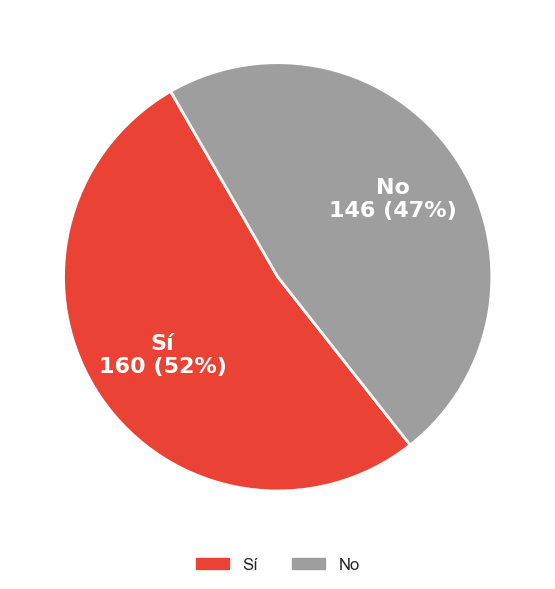

In [70]:
# ...existing code...

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Colores Google Slides style
pie_colors = ['#ea4335', '#9e9e9e']  # rojo, gris

# Filtrar solo respuestas válidas (1=Sí, 2=No)
dist_p1 = convs_con_calif['calificacion_pregunta_1'].value_counts().sort_index()
total_p1 = dist_p1.sum()

# Etiquetas dentro de cada sección (valor y % sin decimales)
labels = [
    f"{'Sí' if int(k)==1 else 'No'}\n{v} ({int(v/total_p1*100)}%)"
    for k, v in zip(dist_p1.index, dist_p1.values)
]

# Fuente Encode Sans (si no está instalada, usará sans-serif)
plt.rcParams['font.family'] = 'Encode Sans, sans-serif'

plt.figure(figsize=(8,6))
wedges, _ = plt.pie(
    dist_p1,
    labels=None,
    autopct=None,
    startangle=120,
    colors=pie_colors[:len(dist_p1)],
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Etiquetas dentro de cada sección con contraste
for i, (w, label) in enumerate(zip(wedges, labels)):
    ang = (w.theta2 + w.theta1)/2.
    x = 0.65 * np.cos(np.deg2rad(ang))
    y = 0.65 * np.sin(np.deg2rad(ang))
    # Color de texto: blanco para rojo, blanco para gris oscuro
    text_color = 'white' if i == 0 or i == 1 else '#222'
    plt.text(
        x, y, label,
        ha='center', va='center',
        fontsize=16, fontweight='bold',
        color=text_color, family='Encode Sans'
    )

plt.gca().set_facecolor('white')
plt.gca().set_aspect('equal')
plt.box(False)

# Leyenda pequeña abajo del gráfico
legend_labels = [
    mpatches.Patch(color=pie_colors[0], label='Sí'),
    mpatches.Patch(color=pie_colors[1], label='No')
]

plt.legend(
    handles=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    fontsize=12,
    frameon=False,
    ncol=2
)

plt.tight_layout()
plt.show()
# ...existing code...

findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Fon

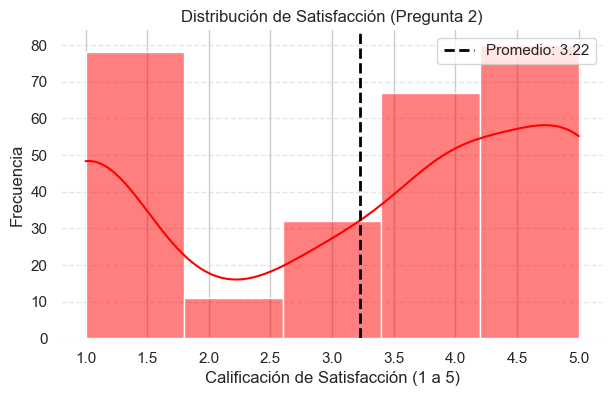

In [71]:
# --- Gráfica de distribución para la segunda métrica ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(p2_valid, bins=5, kde=True, color='red', edgecolor=None)
plt.title('Distribución de Satisfacción (Pregunta 2)')
plt.xlabel('Calificación de Satisfacción (1 a 5)')
plt.ylabel('Frecuencia')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Mostrar línea de promedio
if not p2_valid.empty:
    plt.axvline(p2_valid.mean(), color='black', linestyle='--', linewidth=2, label=f'Promedio: {p2_valid.mean():.2f}')
    plt.legend()

plt.show()
# ...existing code...

### 3.2 Usuarios

In [72]:
# Leer el archivo CSV de usuarios
usuarios_path = '../USUARIOS/Usuarios con acceso a Conecta 2.0 - formato-accesos-conecta2 (1).csv (1).csv'
usuarios_df = pd.read_csv(usuarios_path, encoding='utf-8')
usuarios_df.columns = [col.strip().lower() for col in usuarios_df.columns]  # Normaliza nombres de columnas
df_merged_usuarios = pd.merge(df_merged_final, usuarios_df, left_on='correo', right_on='correo_electronico', how='left')

In [73]:
usuarios_df[usuarios_df.nombre_persona == 'Gustavo Brieva']

,correo_electronico,nombre_posicion,nombre_persona
13,gustavo.brieva@davivienda.com,Desarrollo Conecta 2,Gustavo Brieva


In [74]:
# Comparativo: usuarios habilitados vs usuarios que usan la herramienta
usuarios_habilitados = usuarios_df['correo_electronico'].nunique()
usuarios_que_usan = df_merged_final['correo'].nunique()
porcentaje_uso = usuarios_que_usan / usuarios_habilitados * 100 if usuarios_habilitados else 0

print(f"Usuarios habilitados: {usuarios_habilitados}")
print(f"Usuarios que usan la herramienta: {usuarios_que_usan}")
print(f"Porcentaje de usuarios que usan la herramienta: {porcentaje_uso:.2f}%")

Usuarios habilitados: 1021
Usuarios que usan la herramienta: 346
Porcentaje de usuarios que usan la herramienta: 33.89%


### 3.3 Tiempo Conversación

In [75]:
# Estadísticas de mensajes por conversación
mensajes_por_conversacion = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2').size()

print("\n===== Estadísticas de mensajes por conversación =====")
print(f"Total de conversaciones: {mensajes_por_conversacion.shape[0]}")
print(f"Promedio de mensajes por conversación: {mensajes_por_conversacion.mean():.2f}")
print(f"Mediana de mensajes por conversación: {mensajes_por_conversacion.median():.2f}")
print(f"Desviación estándar: {mensajes_por_conversacion.std():.2f}")
print(f"Máximo de mensajes en una conversación: {mensajes_por_conversacion.max()}")
print(f"Mínimo de mensajes en una conversación: {mensajes_por_conversacion.min()}")
print(f"Percentil 25: {mensajes_por_conversacion.quantile(0.25):.2f}")
print(f"Percentil 75: {mensajes_por_conversacion.quantile(0.75):.2f}")


===== Estadísticas de mensajes por conversación =====
Total de conversaciones: 1122
Promedio de mensajes por conversación: 4.14
Mediana de mensajes por conversación: 3.00
Desviación estándar: 4.14
Máximo de mensajes en una conversación: 32
Mínimo de mensajes en una conversación: 1
Percentil 25: 1.00
Percentil 75: 4.00


In [76]:
df_merged_usuarios['fecha_hora_inicio'] = pd.to_datetime(df_merged_usuarios['fecha_hora_inicio'])
df_merged_usuarios['fecha_hora_fin'] = pd.to_datetime(df_merged_usuarios['fecha_hora_fin'])

In [77]:
# Calcular duración de cada conversación (en minutos)
df_merged_usuarios['duracion_min'] = (
    df_merged_usuarios['fecha_hora_fin'] - df_merged_usuarios['fecha_hora_inicio']
).dt.total_seconds() / 60

# Agrupar por conversación y calcular estadísticas
stats_conversacion = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2').agg(
    mensajes=('fk_tbl_conversaciones_conecta2', 'count'),
    duracion_min=('duracion_min', 'max')  # max porque todas las filas de una conversación tienen la misma duración
)

# Estadísticas descriptivas de duración
print("\n===== Estadísticas de duración por conversación =====")
print(f"Promedio de duración (min): {stats_conversacion['duracion_min'].mean():.2f}")
print(f"Mediana de duración (min): {stats_conversacion['duracion_min'].median():.2f}")
print(f"Desviación estándar: {stats_conversacion['duracion_min'].std():.2f}")
print(f"Duración mínima: {stats_conversacion['duracion_min'].min():.2f}")
print(f"Duración máxima: {stats_conversacion['duracion_min'].max():.2f}")

# Relación entre duración y cantidad de mensajes
print("\n===== Relación duración vs cantidad de mensajes =====")
print(stats_conversacion[['mensajes', 'duracion_min']].corr())


===== Estadísticas de duración por conversación =====
Promedio de duración (min): 21.80
Mediana de duración (min): 6.23
Desviación estándar: 70.87
Duración mínima: 0.17
Duración máxima: 1133.60

===== Relación duración vs cantidad de mensajes =====
              mensajes  duracion_min
mensajes      1.000000     -0.027968
duracion_min -0.027968      1.000000


In [78]:
# Filtrar la conversación más larga (mayor duración en minutos)
id_conversacion_larga = stats_conversacion['duracion_min'].idxmax()
conversacion_larga = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'] == id_conversacion_larga]

print(f"ID de la conversación más larga: {id_conversacion_larga}")
print(f"Duración (min): {stats_conversacion.loc[id_conversacion_larga, 'duracion_min']:.2f}")
print(f"Mensajes enviados: {stats_conversacion.loc[id_conversacion_larga, 'mensajes']}")

df_merged_usuarios[df_merged_usuarios.fk_tbl_conversaciones_conecta2 == id_conversacion_larga]

ID de la conversación más larga: 243
Duración (min): 1133.60
Mensajes enviados: 4


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2,correo_electronico,nombre_posicion,nombre_persona,duracion_min
834,481,243,que clima es hoy en bogota,"Lo siento, no puedo proporcionar información sobre el clima. ¿En qué tema bancario de Davivienda puedo ayudarte?",<NA>,<NA>,20250825,243,2025-08-24 12:41:29,2025-08-25 07:35:05,jppenaf@davivienda.com,NaN,NaN,20250825,1.0,5.0,jppenaf@davivienda.com,Coordinadora PO,Jeimy Peña,1133.6
835,481,243,que clima es hoy en bogota,"Lo siento, no puedo proporcionar información sobre el clima. ¿En qué tema bancario de Davivienda puedo ayudarte?",<NA>,<NA>,20250825,243,2025-08-24 12:41:29,2025-08-25 07:35:05,jppenaf@davivienda.com,NaN,NaN,20250826,1.0,5.0,jppenaf@davivienda.com,Coordinadora PO,Jeimy Peña,1133.6
2498,481,243,que clima es hoy en bogota,"Lo siento, no puedo proporcionar información sobre el clima. ¿En qué tema bancario de Davivienda puedo ayudarte?",<NA>,<NA>,20250826,243,2025-08-24 12:41:29,2025-08-25 07:35:05,jppenaf@davivienda.com,NaN,NaN,20250825,1.0,5.0,jppenaf@davivienda.com,Coordinadora PO,Jeimy Peña,1133.6
2499,481,243,que clima es hoy en bogota,"Lo siento, no puedo proporcionar información sobre el clima. ¿En qué tema bancario de Davivienda puedo ayudarte?",<NA>,<NA>,20250826,243,2025-08-24 12:41:29,2025-08-25 07:35:05,jppenaf@davivienda.com,NaN,NaN,20250826,1.0,5.0,jppenaf@davivienda.com,Coordinadora PO,Jeimy Peña,1133.6


### 3.4 Motivo Experto

In [79]:
# Analizar la columna 'motivo_experto' a nivel conversacional
# filepath: c:\Users\gabrieva\Visual_Studio_Code_Files\[Conecta] Tablero BI\NOTEBOOKS\kpis_metricas.ipynb

# Agrupa por conversación y toma el primer motivo_experto de cada conversación
motivos_por_conversacion = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first()

# Conteo de motivos únicos
conteo_motivos = motivos_por_conversacion.value_counts(dropna=False)

print("===== Análisis de 'motivo_experto' por conversación =====")
print("Total de conversaciones analizadas:", len(motivos_por_conversacion))
print("\nDistribución de motivos:")
print(conteo_motivos)

# Porcentaje de cada motivo
porcentaje_motivos = conteo_motivos / len(motivos_por_conversacion) * 100
print("\nPorcentaje por motivo:")
print(porcentaje_motivos.round(2))

===== Análisis de 'motivo_experto' por conversación =====
Total de conversaciones analizadas: 1122

Distribución de motivos:
motivo_experto
None            991
Usuario          75
IA               50
Usuario + IA      6
Name: count, dtype: int64

Porcentaje por motivo:
motivo_experto
None            88.32
Usuario          6.68
IA               4.46
Usuario + IA     0.53
Name: count, dtype: float64


===== Análisis de número de mensajes por motivo_experto =====
                count       mean  median       std  min  max
motivo_experto                                              
Usuario            75   7.066667     5.0  5.075999    1   24
IA                 50   9.780000    12.0  6.819211    2   32
Usuario + IA        6  10.166667     7.5  8.750238    3   24


<Figure size 1000x500 with 0 Axes>

findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Fon

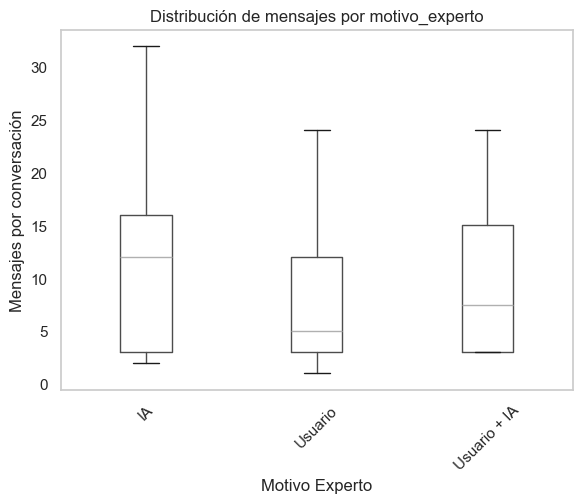

In [80]:
# Agrupa por conversación y obtiene el motivo y el número de mensajes
mensajes_motivo = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2').agg(
    motivo_experto=('motivo_experto', 'first'),
    mensajes=('fk_tbl_conversaciones_conecta2', 'count')
)

# Estadísticas descriptivas por motivo
resumen_motivo = mensajes_motivo.groupby('motivo_experto')['mensajes'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).sort_values('count', ascending=False)

print("===== Análisis de número de mensajes por motivo_experto =====")
print(resumen_motivo)

# Si quieres ver la distribución de mensajes por motivo en forma de tabla:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
mensajes_motivo.boxplot(column='mensajes', by='motivo_experto', grid=False, rot=45)
plt.title('Distribución de mensajes por motivo_experto')
plt.suptitle('')
plt.xlabel('Motivo Experto')
plt.ylabel('Mensajes por conversación')
plt.show()

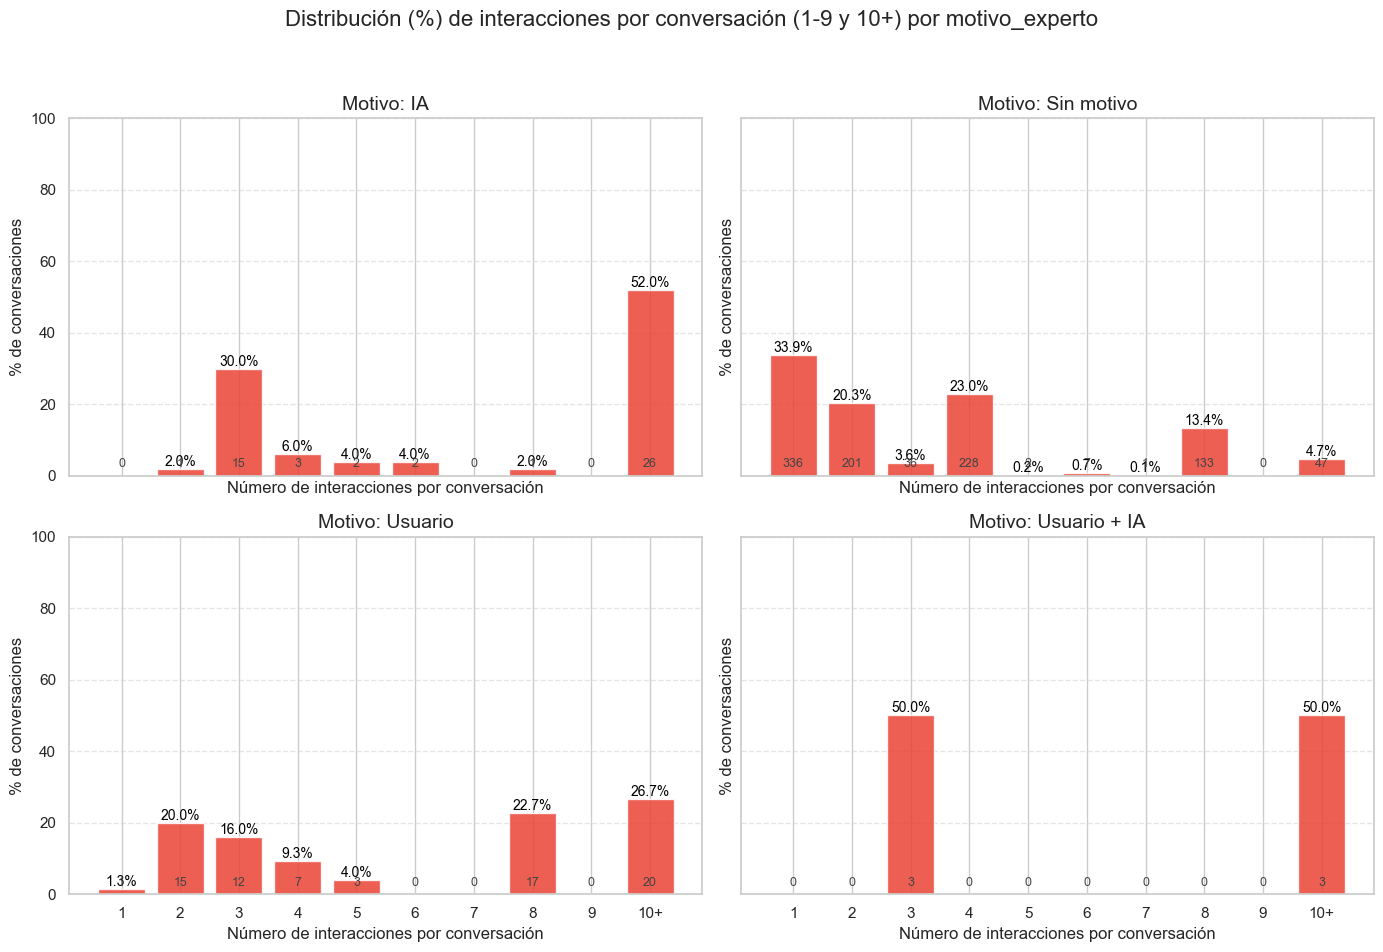

In [100]:
# Histograma por motivo_experto en un grid 2x2, usando porcentaje y mostrando conteo al fondo de cada barra
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['font.family'] = 'sans-serif'

def agrupar_mensajes_10(x):
    return str(int(x)) if 1 <= x <= 9 else '10+'

mensajes_motivo['mensajes_grupo_10'] = mensajes_motivo['mensajes'].apply(agrupar_mensajes_10)
grupos_10 = [str(i) for i in range(1, 10)] + ['10+']

motivos = mensajes_motivo['motivo_experto'].fillna('Sin motivo').unique()
motivos = sorted(motivos, key=lambda x: str(x))

top_motivos = pd.Series(motivos)
if len(top_motivos) > 4:
    motivo_counts = mensajes_motivo['motivo_experto'].fillna('Sin motivo').value_counts()
    top_motivos = motivo_counts.index[:4]
else:
    top_motivos = motivos[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, motivo in enumerate(top_motivos):
    datos = mensajes_motivo[mensajes_motivo['motivo_experto'].fillna('Sin motivo') == motivo]['mensajes_grupo_10']
    counts = datos.value_counts().reindex(grupos_10, fill_value=0)
    total = counts.sum()
    porcentajes = counts / total * 100 if total > 0 else counts
    bars = axes[i].bar(grupos_10, porcentajes, color='#ea4335', edgecolor='white', alpha=0.85)
    axes[i].set_title(f"Motivo: {motivo}", fontsize=14)
    axes[i].set_ylabel('% de conversaciones')
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    axes[i].set_ylim(bottom=0, top=100)
    axes[i].set_xlabel('Número de interacciones por conversación')
    axes[i].set_xticks(range(len(grupos_10)))
    axes[i].set_xticklabels(grupos_10, rotation=0)
    # Etiquetas de porcentaje arriba y conteo abajo de cada barra
    for bar, y, c in zip(bars, porcentajes, counts):
        if y > 0:
            height = bar.get_height()
            y_pos = min(height, axes[i].get_ylim()[1] * 0.98)
            axes[i].text(bar.get_x() + bar.get_width()/2, y_pos, f"{y:.1f}%", ha='center', va='bottom', fontsize=10, color='black', clip_on=True)
        # Mostrar el conteo en la base de la barra (siempre)
        axes[i].text(bar.get_x() + bar.get_width()/2, 1.5, f"{int(c)}", ha='center', va='bottom', fontsize=9, color='#444', clip_on=True)

plt.suptitle('Distribución (%) de interacciones por conversación (1-9 y 10+) por motivo_experto', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Interpretación:
# Cada gráfico muestra la distribución porcentual de conversaciones según el número de mensajes (1-9 y 10+) para cada motivo_experto.
# Arriba de cada barra: % de conversaciones. Abajo: cantidad absoluta.
# Así puedes comparar cómo varía la longitud de las conversaciones según el motivo de derivación.

In [ ]:
# 1. Normalizar la columna 'calificacion': solo conservar 'Mal', el resto asignar None
# Solución: verifica si x es NA antes de comparar
df_merged_usuarios['calificacion_filtrada'] = df_merged_usuarios['calificacion'].apply(
    lambda x: x if pd.notna(x) and x == 'Mal' else None
)

# 2. Agrupar por conversación y motivo_experto, contar calificaciones negativas
calif_motivo = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['fk_tbl_conversaciones_conecta2', 'motivo_experto_norm'])['calificacion_filtrada']
    .apply(lambda x: (x == 'Mal').sum())
    .reset_index(name='mal_count')
)

# 3. Resumir por motivo_experto
resumen_motivo_mal = calif_motivo.groupby('motivo_experto_norm')['mal_count'].agg(['sum', 'count']).sort_values('sum', ascending=False)
resumen_motivo_mal['porcentaje_conversaciones_con_mal'] = resumen_motivo_mal['sum'] / resumen_motivo_mal['count'] * 100

In [82]:
# 1. Identificar conversaciones con motivo 'Usuario' pero sin calificación negativa
usuario_convs = df_merged_usuarios[(df_merged_usuarios['motivo_experto'] == 'Usuario') | (df_merged_usuarios['motivo_experto'] == 'Usuario + IA')]
usuario_convs_grouped = usuario_convs.groupby('fk_tbl_conversaciones_conecta2')['calificacion_filtrada'].apply(lambda x: (x == 'Mal').any()).reset_index()
sin_mal_usuario = usuario_convs_grouped[usuario_convs_grouped['calificacion_filtrada'] == False]['fk_tbl_conversaciones_conecta2']
convs_detalle = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'].isin(sin_mal_usuario)]

# 2. Buscar la palabra 'Mal' en los valores de las columnas relevantes
# Si 'Mal' aparece en alguna columna tipo texto (ejemplo: 'pregunta'), asignar 'Mal' a 'calificacion_filtrada'
mask_mal_pregunta = convs_detalle['pregunta'].astype(str).str.contains(r'\bMal\b', case=False, na=False)
convs_detalle.loc[mask_mal_pregunta, 'calificacion_filtrada'] = 'Mal'

# 3. Actualizar el DataFrame original con los nuevos valores
df_merged_usuarios.loc[convs_detalle.index, 'calificacion_filtrada'] = convs_detalle['calificacion_filtrada']

# 4. Repetir el análisis
# Agrupa por conversación y motivo, y verifica si hay al menos un 'Mal'
calif_motivo_bin = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['fk_tbl_conversaciones_conecta2', 'motivo_experto_norm'])['calificacion_filtrada']
    .apply(lambda x: (x == 'Mal').any())
    .reset_index(name='tiene_mal')
)

# Resumir por motivo_experto
resumen_motivo_mal_bin = calif_motivo_bin.groupby('motivo_experto_norm')['tiene_mal'].agg(['sum', 'count'])
resumen_motivo_mal_bin['porcentaje_conversaciones_con_mal'] = resumen_motivo_mal_bin['sum'] / resumen_motivo_mal_bin['count'] * 100

print("===== Porcentaje de conversaciones con al menos un 'Mal' por motivo_experto =====")
print(resumen_motivo_mal_bin)

===== Porcentaje de conversaciones con al menos un 'Mal' por motivo_experto =====
                     sum  count  porcentaje_conversaciones_con_mal
motivo_experto_norm                                               
IA                     9     50                           18.00000
Sin motivo            82    991                            8.27447
Usuario               75     75                          100.00000
Usuario + IA           6      6                          100.00000


In [83]:
# Análisis: ¿Cuántas calificaciones 'Mal' hay por motivo_experto?

# 1. Agrupa por conversación y motivo_experto, cuenta calificaciones 'Mal' por conversación
mal_por_conversacion = (
    df_merged_usuarios
    .assign(motivo_experto_norm = df_merged_usuarios['motivo_experto'].fillna('Sin motivo'))
    .groupby(['fk_tbl_conversaciones_conecta2', 'motivo_experto_norm'])['calificacion_filtrada']
    .apply(lambda x: (x == 'Mal').sum())
    .reset_index(name='mal_count')
)

# 2. Resumir por motivo_experto: suma total de 'Mal' y número de conversaciones
resumen_mal_motivo = mal_por_conversacion.groupby('motivo_experto_norm')['mal_count'].agg(['sum', 'count'])
print("===== Calificaciones 'Mal' por motivo_experto =====")
print(resumen_mal_motivo)

# 3. Conversaciones sin motivo_experto explícito ('Sin motivo') con al menos una calificación 'Mal'
sin_motivo_mal = mal_por_conversacion[
    (mal_por_conversacion['motivo_experto_norm'] == 'Sin motivo') & (mal_por_conversacion['mal_count'] > 0)
]
print(f"\nConversaciones 'Sin motivo' con al menos una calificación 'Mal': {sin_motivo_mal.shape[0]}")
print(sin_motivo_mal[['fk_tbl_conversaciones_conecta2', 'mal_count']].head())

===== Calificaciones 'Mal' por motivo_experto =====
                     sum  count
motivo_experto_norm            
IA                    24     50
Sin motivo           164    991
Usuario              304     75
Usuario + IA          15      6

Conversaciones 'Sin motivo' con al menos una calificación 'Mal': 82
     fk_tbl_conversaciones_conecta2  mal_count
13                               58          4
64                              109          4
82                              127          4
211                             259          4
229                             277          4


===== Promedio de calificaciones 'Mal' por conversación para cada motivo_experto =====
  motivo_experto_norm  promedio_mal_por_conversacion
0                  IA                       0.480000
1          Sin motivo                       0.165489
2             Usuario                       4.053333
3        Usuario + IA                       2.500000


findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Font family 'Encode Sans' not found.
findfont: Fon

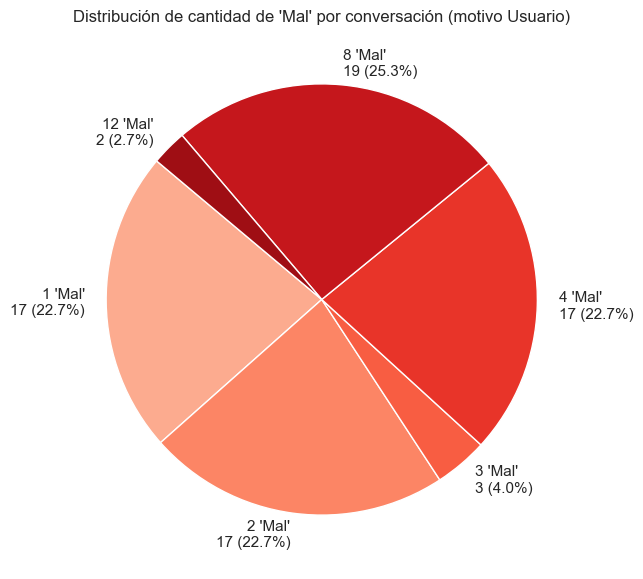

In [84]:
# Distribución de calificaciones 'Mal' promedio por motivo_experto

# Calcula el promedio de calificaciones 'Mal' por conversación para cada motivo
promedio_mal_por_motivo = mal_por_conversacion.groupby('motivo_experto_norm')['mal_count'].mean().reset_index()
promedio_mal_por_motivo = promedio_mal_por_motivo.rename(columns={'mal_count': 'promedio_mal_por_conversacion'})

print("===== Promedio de calificaciones 'Mal' por conversación para cada motivo_experto =====")
print(promedio_mal_por_motivo)

import matplotlib
cmap = matplotlib.colormaps['Reds']

mal_usuario = mal_por_conversacion[mal_por_conversacion['motivo_experto_norm'] == 'Usuario']['mal_count']
mal_usuario_counts = mal_usuario.value_counts().sort_index()

# Generar colores distintos para cada sección
colors = [cmap(0.3 + 0.7*i/len(mal_usuario_counts)) for i in range(len(mal_usuario_counts))]

# Etiquetas con cantidad y porcentaje
total = mal_usuario_counts.sum()
labels = [f"{k} 'Mal'\n{v} ({v/total:.1%})" for k, v in zip(mal_usuario_counts.index, mal_usuario_counts.values)]

plt.figure(figsize=(7,7))
plt.pie(
    mal_usuario_counts,
    labels=labels,
    autopct=None,  # ya está en la etiqueta
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Distribución de cantidad de 'Mal' por conversación (motivo Usuario)")
plt.show()

### 3.5 Conversaciones con Mala Calificación (Sin PE)

In [40]:
# Imprimir tabla y mensajes con ancho dinámico y saltos de línea para preguntas/respuestas largas

def print_multiline(text, ancho=80, indent=0):
    import textwrap
    if pd.isna(text):
        return ""
    return ("\n" + " " * indent).join(textwrap.wrap(str(text), ancho))

# Imprimir tabla de conversaciones
print("\nConversaciones 'Sin motivo' (Sin Paso Experto) con calificación negativa ('Mal'):")
print("-" * 90)
print(f"{'Índice':<8}{'ID Conversación':<20}{'Mensajes':<12}{'Calif. Mal':<12}")
print("-" * 90)
for idx, row in sin_motivo_mal.reset_index().iterrows():
    conv_id = row['fk_tbl_conversaciones_conecta2']
    mal_count = row['mal_count']
    total_mensajes = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'] == conv_id].shape[0]
    print(f"{idx:<8}{str(conv_id):<20}{str(total_mensajes):<12}{str(mal_count):<12}")
print("-" * 90)

# Selección de conversación
try:
    seleccion = int(input("Ingrese el índice de la conversación que desea revisar: "))
except Exception:
    seleccion = 0

if 0 <= seleccion < len(sin_motivo_mal):
    conv_id = sin_motivo_mal.reset_index().iloc[seleccion]['fk_tbl_conversaciones_conecta2']
    conversacion = df_merged_usuarios[df_merged_usuarios['fk_tbl_conversaciones_conecta2'] == conv_id]
    print(f"\n=== Conversación ID {conv_id} ===")
    print(f"Total de mensajes: {conversacion.shape[0]}")
    print("-" * 160)
    print(f"{'Consecutivo':<12}{'Fecha':<20}{'Pregunta':<60}{'Respuesta':<60}{'Calif.'}")
    print("-" * 160)
    for idx, row in enumerate(conversacion.itertuples(), 1):
        pregunta = print_multiline(getattr(row, 'pregunta', ''), ancho=58, indent=14)
        respuesta = print_multiline(getattr(row, 'respuesta', ''), ancho=58, indent=14)
        fecha = str(getattr(row, 'fecha_hora_inicio', ''))
        calif = getattr(row, 'calificacion_filtrada', '')
        calif_str = "Mal" if calif == 'Mal' else ""
        print(f"{idx:<12}{fecha:<20}{pregunta:<60}{respuesta:<60}{calif_str}")
    print("-" * 160)
else:
    print("No hay conversaciones 'Sin motivo' con calificación negativa para mostrar o el índice es inválido.")


Conversaciones 'Sin motivo' (Sin Paso Experto) con calificación negativa ('Mal'):
------------------------------------------------------------------------------------------
Índice  ID Conversación     Mensajes    Calif. Mal  
------------------------------------------------------------------------------------------
0       58                  8           4           
1       109                 8           4           
2       127                 8           4           
3       259                 12          4           
4       277                 8           4           
5       350                 4           4           
6       366                 4           4           
7       374                 4           4           
8       393                 8           4           
9       407                 8           4           
10      433                 4           4           
11      437                 8           4           
12      439                 8           8     

### 3.6 Lo Siento Flag

In [41]:
# Crear un flag para identificar respuestas que contienen 'lo siento' (sin distinción de mayúsculas/minúsculas)
df_merged_usuarios['flag_lo_siento'] = df_merged_usuarios['respuesta'].astype(str).str.contains('lo siento', case=False, na=False)

# Filtrar el DataFrame para mostrar solo las filas donde el flag es True
df_lo_siento = df_merged_usuarios[df_merged_usuarios['flag_lo_siento']]

print(f"Conversaciones con respuesta que contiene 'lo siento': {len(df_lo_siento)}")
df_lo_siento.head()

Conversaciones con respuesta que contiene 'lo siento': 225


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2,correo_electronico,nombre_posicion,nombre_persona,duracion_min,calificacion_filtrada,flag_lo_siento
70,84,61,Salió por el momento no podemos procesar la in...,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,61,2025-08-24 09:33:06,2025-08-24 09:36:23,crluna@davivienda.com,NaN,IA,20250825,1.0,NaN,crluna@davivienda.com,Profesional Conecta,Clara R Luna,3.283333,None,True
71,84,61,Salió por el momento no podemos procesar la in...,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,61,2025-08-24 09:33:06,2025-08-24 09:36:23,crluna@davivienda.com,NaN,IA,20250826,1.0,NaN,crluna@davivienda.com,Profesional Conecta,Clara R Luna,3.283333,None,True
138,118,77,Montos mínimos de financiación Agropecuario,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,77,2025-08-24 09:48:48,2025-08-24 09:52:27,pablo.hernandezambrano@davivienda.com,NaN,IA,20250825,NaN,NaN,pablo.hernandezambrano@davivienda.com,Profesional Conecta,Pablo Hernandez,3.650000,None,True
139,118,77,Montos mínimos de financiación Agropecuario,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,77,2025-08-24 09:48:48,2025-08-24 09:52:27,pablo.hernandezambrano@davivienda.com,NaN,IA,20250826,NaN,NaN,pablo.hernandezambrano@davivienda.com,Profesional Conecta,Pablo Hernandez,3.650000,None,True
236,167,95,Cuanto se demora el Jefe comercial Pyme en rev...,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,95,2025-08-24 10:07:09,2025-08-24 10:12:13,pablo.hernandezambrano@davivienda.com,NaN,IA,20250825,NaN,NaN,pablo.hernandezambrano@davivienda.com,Profesional Conecta,Pablo Hernandez,5.066667,None,True


In [42]:
# --- Análisis de flag 'lo siento' por motivo_experto y comparación global ---

# Total de conversaciones únicas
total_convs = df_merged_usuarios['fk_tbl_conversaciones_conecta2'].nunique()

# Conversaciones únicas con flag 'lo siento'
convs_lo_siento_ids = df_lo_siento['fk_tbl_conversaciones_conecta2'].unique()
num_convs_lo_siento = len(convs_lo_siento_ids)
porc_convs_lo_siento = num_convs_lo_siento / total_convs * 100 if total_convs else 0

print(f"De las {total_convs} conversaciones, {num_convs_lo_siento} ({porc_convs_lo_siento:.2f}%) presentaron el filtro 'lo siento'.")

# Distribución de motivo_experto en conversaciones con 'lo siento'
motivo_dist_lo_siento = df_lo_siento.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first().value_counts(dropna=False)
motivo_dist_lo_siento_pct = motivo_dist_lo_siento / num_convs_lo_siento * 100

print("\nDistribución de motivo_experto en conversaciones con 'lo siento':")
for motivo, count in motivo_dist_lo_siento.items():
    pct = motivo_dist_lo_siento_pct[motivo]
    print(f"{motivo}: {count} ({pct:.2f}%)")

# Distribución de motivo_experto en el total de conversaciones
motivo_dist_total = df_merged_usuarios.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto'].first().value_counts(dropna=False)
motivo_dist_total_pct = motivo_dist_total / total_convs * 100

print("\nDistribución de motivo_experto en el total de conversaciones:")
for motivo, count in motivo_dist_total.items():
    pct = motivo_dist_total_pct[motivo]
    print(f"{motivo}: {count} ({pct:.2f}%)")

# Comparativo tabla resumen
import pandas as pd

tabla_comparativa = pd.DataFrame({
    'Convs_lo_siento': motivo_dist_lo_siento,
    '%_lo_siento': motivo_dist_lo_siento_pct,
    'Convs_total': motivo_dist_total,
    '%_total': motivo_dist_total_pct
}).fillna(0)

print("\nTabla comparativa motivo_experto (con 'lo siento' vs total):")
print(tabla_comparativa)

De las 1122 conversaciones, 76 (6.77%) presentaron el filtro 'lo siento'.

Distribución de motivo_experto en conversaciones con 'lo siento':
IA: 46 (60.53%)
None: 26 (34.21%)
Usuario + IA: 3 (3.95%)
Usuario: 1 (1.32%)

Distribución de motivo_experto en el total de conversaciones:
None: 991 (88.32%)
Usuario: 75 (6.68%)
IA: 50 (4.46%)
Usuario + IA: 6 (0.53%)

Tabla comparativa motivo_experto (con 'lo siento' vs total):
                Convs_lo_siento  %_lo_siento  Convs_total    %_total
motivo_experto                                                      
IA                           46    60.526316           50   4.456328
Usuario                       1     1.315789           75   6.684492
Usuario + IA                  3     3.947368            6   0.534759
None                         26    34.210526          991  88.324421


In [43]:
df_lo_siento.head(2)

,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2,correo_electronico,nombre_posicion,nombre_persona,duracion_min,calificacion_filtrada,flag_lo_siento
70,84,61,Salió por el momento no podemos procesar la in...,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,61,2025-08-24 09:33:06,2025-08-24 09:36:23,crluna@davivienda.com,NaN,IA,20250825,1.0,NaN,crluna@davivienda.com,Profesional Conecta,Clara R Luna,3.283333,None,True
71,84,61,Salió por el momento no podemos procesar la in...,"Lo siento, no encontré información relacionada...",<NA>,<NA>,20250825,61,2025-08-24 09:33:06,2025-08-24 09:36:23,crluna@davivienda.com,NaN,IA,20250826,1.0,NaN,crluna@davivienda.com,Profesional Conecta,Clara R Luna,3.283333,None,True


#### 3.6.1 Detalle Preguntas

In [44]:
# Cargar las variables de entorno desde el archivo .env
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

# Configurar el cliente de Gemini (¡Esta es la forma correcta!)
genai.configure(api_key=GOOGLE_API_KEY)

In [45]:
def ejecutar_prompt(prompt, model_name="gemini-1.5-flash-latest", max_intentos=3):
    """
    Ejecuta un prompt en el modelo de Gemini y extrae un JSON válido de la respuesta.
    Maneja reintentos en caso de errores de API o de decodificación JSON.
    
    *** CORRECCIÓN: Esta función ahora usa genai.GenerativeModel() ***
    """
    # Se crea una instancia del modelo que se va a utilizar
    model = genai.GenerativeModel(model_name)
    
    for intento in range(max_intentos):
        try:
            # Generar contenido con el modelo
            # La llamada se hace directamente sobre el objeto 'model'
            response = model.generate_content(prompt)
            
            # Extraer el texto de la respuesta
            respuesta_texto = response.text.strip()
            
            # Extraer JSON válido si está rodeado de markdown
            json_match = re.search(r"```json\s*([\s\S]*?)\s*```", respuesta_texto)
            if json_match:
                respuesta_json = json_match.group(1)
            else:
                respuesta_json = respuesta_texto
            
            return json.loads(respuesta_json)

        except json.JSONDecodeError as e:
            print(f"Error de decodificación JSON en intento {intento + 1}/{max_intentos}. Respuesta recibida: {respuesta_texto}")
        except Exception as e:
            # Captura errores más específicos de la API si están disponibles
            print(f"Error general de API en intento {intento + 1}/{max_intentos}: {type(e).__name__} - {e}")
            time.sleep(5)

    # Si todos los intentos fallan, devolver un JSON de error
    return {
        "es_relevante_davivienda": None,
        "tema_principal": "Error de Procesamiento",
        "intencion_usuario": "N/A",
        "entidades_clave": [],
        "prioridad_sugerida": "Baja",
        "accion_recomendada": f"No se pudo procesar la pregunta después de {max_intentos} intentos."
    }

# La función 'analizar_pregunta_no_resuelta' no necesita cambios en su lógica interna,
# ya que solo construye el prompt y llama a 'ejecutar_prompt'.
def analizar_pregunta_no_resuelta(pregunta_funcionario: str):
    """
    Analiza una pregunta de un funcionario que Conecta 2.0 no pudo responder,
    utilizando Gemini para identificar brechas de conocimiento.
    """
    prompt_template = f"""
    **PERSONA:**
    Eres un Analista Experto en Gestión del Conocimiento para el Banco Davivienda en Colombia. 
    Tu misión es analizar las preguntas de los funcionarios que el asistente virtual "Conecta 2.0" no pudo resolver (respondió "Lo siento, no tengo información"). 
    Tu análisis será utilizado por el equipo de contenidos para crear o actualizar la base de conocimiento.

    **CONTEXTO:**
    - El usuario es un funcionario del banco.
    - La pregunta fue realizada en un contexto de soporte interno.
    - Tu objetivo es identificar si la pregunta revela una brecha de conocimiento relevante y proporcionar detalles para solucionarla.

    **TAREA:**
    Analiza la "Pregunta a Analizar" y devuelve un objeto JSON con la siguiente estructura. Sé riguroso y objetivo.

    **FORMATO DE SALIDA (JSON Requerido):**
    ```json
    {{
      "es_relevante_davivienda": "boolean, true si la pregunta es sobre productos, servicios o procesos de Davivienda o del sector bancario colombiano. false si es off-topic (ej. clima, deportes).",
      "tema_principal": "string, categoriza el tema principal. Ejemplos: 'Crédito Hipotecario', 'Tarjeta de Crédito', 'Cuenta de Ahorros', 'CDT', 'Transferencias', 'Seguridad Bancaria', 'Procesos Internos', 'Off-topic'.",
      "intencion_usuario": "string, describe la necesidad del usuario. Ejemplos: 'Consultar procedimiento', 'Buscar requisitos', 'Encontrar documento/link', 'Consultar tasa/tarifa', 'Resolver un error', 'Pregunta general'.",
      "entidades_clave": "array de strings, extrae las palabras o conceptos clave de la pregunta. Ej: ['portafolio', 'cancelación', 'extractos'].",
      "prioridad_sugerida": "string, asigna una prioridad ('Alta', 'Media', 'Baja') para el equipo de contenido. 'Alta' para temas críticos o muy frecuentes.",
      "accion_recomendada": "string, una instrucción clara y concisa para el equipo de contenido. Ej: 'Crear artículo sobre el proceso de pignoración de CDT', 'Añadir sección de errores comunes en transferencias a Nequi', 'Descartar por ser off-topic'."
    }}
    ```

    **EJEMPLOS:**

    **Ejemplo 1 (Relevante):**
    *   **Pregunta a Analizar:** "buenos dias, como hago para cancelarle un cdt digital a un cliente que esta en el exterior?"
    *   **Salida Esperada:**
    ```json
    {{
      "es_relevante_davivienda": true,
      "tema_principal": "CDT",
      "intencion_usuario": "Consultar procedimiento",
      "entidades_clave": ["cdt digital", "cancelar", "cliente en el exterior"],
      "prioridad_sugerida": "Alta",
      "accion_recomendada": "Crear artículo detallado sobre el procedimiento de cancelación de CDT Digital para clientes en el exterior, incluyendo requisitos y canales."
    }}
    ```

    **Ejemplo 2 (No Relevante):**
    *   **Pregunta a Analizar:** "cuanto es la cuota de manejo de la tarjeta de credito de bancolombia"
    *   **Salida Esperada:**
    ```json
    {{
      "es_relevante_davivienda": false,
      "tema_principal": "Off-topic",
      "intencion_usuario": "Pregunta general",
      "entidades_clave": ["cuota de manejo", "tarjeta de credito", "bancolombia"],
      "prioridad_sugerida": "Baja",
      "accion_recomendada": "Descartar. La consulta es sobre un producto de otra entidad (Bancolombia)."
    }}
    ```
    ---
    **PREGUNTA A ANALIZAR:**
    "{pregunta_funcionario}"
    """
    return ejecutar_prompt(prompt_template)

In [46]:
# La función de procesamiento tampoco necesita cambios.
def procesar_y_reportar_knowledge_gaps(df_lo_siento: pd.DataFrame):
     # (El código de esta función permanece igual que en la respuesta anterior)
     # ...
    # Lista para almacenar los resultados del análisis JSON
    resultados_json = []

    print(f"Iniciando análisis de {len(df_lo_siento)} preguntas no resueltas...")
    
    # Usar tqdm para una barra de progreso
    for pregunta in tqdm(df_lo_siento['pregunta'], desc="Analizando preguntas"):
        if pd.notna(pregunta) and pregunta.strip() != "":
            resultado = analizar_pregunta_no_resuelta(pregunta)
            resultados_json.append(resultado)
        else:
            # Manejar celdas vacías o nulas
            resultados_json.append(None)
            
    # Añadir los resultados como una nueva columna temporal
    df_lo_siento['analisis_json_raw'] = resultados_json
    
    # Expandir la columna JSON en múltiples columnas para facilitar el análisis
    df_analizado = pd.json_normalize(df_lo_siento['analisis_json_raw'])
    
    # Unir el DataFrame analizado con el original
    df_final = pd.concat([df_lo_siento.reset_index(drop=True), df_analizado.reset_index(drop=True)], axis=1)

    # --- Generación del Reporte para el Equipo de Contenidos ---
    print("\n" + "="*50)
    print("REPORTE DE BRECHAS DE CONOCIMIENTO (KNOWLEDGE GAPS)")
    print("="*50)

    # Filtrar solo las preguntas que el agente consideró relevantes
    df_relevante = df_final[df_final['es_relevante_davivienda'] == True]
    
    if not df_relevante.empty:
        print(f"\nSe encontraron {len(df_relevante)} preguntas relevantes que Conecta 2.0 no pudo responder.\n")
        
        print("--- Temas Principales Detectados ---")
        print(df_relevante['tema_principal'].value_counts().to_string())
        
        print("\n--- Intenciones de Usuario más Frecuentes ---")
        print(df_relevante['intencion_usuario'].value_counts().to_string())
        
        print("\n--- Distribución de Prioridad Sugerida ---")
        print(df_relevante['prioridad_sugerida'].value_counts().to_string())

        # print("\n--- Top 10 Acciones Recomendadas con Prioridad ALTA ---")
        # Agrupar acciones recomendadas, contarlas y mostrar las más frecuentes con prioridad "Alta"
        # acciones_altas = df_relevante[df_relevante['prioridad_sugerida'] == 'Alta']['accion_recomendada'].value_counts().nlargest(10)
        # print(acciones_altas.to_string())
    else:
        print("\nNo se encontraron brechas de conocimiento relevantes en este lote.")
        
    print("\n" + "="*50)
    # print("Análisis completado.")
    
    # Opcional: Eliminar la columna JSON cruda si no se necesita
    df_final.drop(columns=['analisis_json_raw'], inplace=True, errors='ignore')
    
    return df_final

# Ejecutar el flujo completo de análisis y reporte
# df_analizado_final = procesar_y_reportar_knowledge_gaps(df_lo_siento)

In [47]:
# PREGUNTAS RELEVANTES
pd.set_option('display.max_colwidth', None)  # Mostrar texto completo en columnas
display(df_analizado_final[['pregunta', 'respuesta', 'correo', 'es_relevante_davivienda', 'tema_principal', 'intencion_usuario', 'entidades_clave', 'prioridad_sugerida', 'accion_recomendada']].tail(2))

NameError: name 'df_analizado_final' is not defined

In [ ]:
# PREGUNTAS NO RELEVANTES

display(df_analizado_final[df_analizado_final.es_relevante_davivienda == False].head(2))

,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,archivo_origen_preg,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,archivo_origen_conv,calificacion_pregunta_1,calificacion_pregunta_2,correo_electronico,nombre_posicion,nombre_persona,duracion_min,calificacion_filtrada,flag_lo_siento,es_relevante_davivienda,tema_principal,intencion_usuario,entidades_clave,prioridad_sugerida,accion_recomendada
23,481,243,que clima es hoy en bogota,"Lo siento, no puedo proporcionar información sobre el clima. ¿En qué tema bancario de Davivienda puedo ayudarte?",<NA>,<NA>,20250825,243,2025-08-24 12:41:29,2025-08-25 07:35:05,jppenaf@davivienda.com,NaN,NaN,20250825,1.0,5.0,jppenaf@davivienda.com,Coordinadora PO,Jeimy Peña,1133.600000,None,True,False,Off-topic,Pregunta general,"[clima, bogota]",Baja,"Descartar. La pregunta no está relacionada con Davivienda, sus productos o servicios."
26,531,273,Para plasmar en camisetas de funcionarios,"Lo siento, no encontré información relacionada a este tema. ¿Podrías reformular la pregunta?",<NA>,<NA>,20250825,273,2025-08-25 07:57:29,2025-08-25 08:03:40,camila.santamaria@davivienda.com,NaN,IA,20250825,NaN,NaN,NaN,NaN,NaN,6.183333,None,True,False,Off-topic,Pregunta general,"[camisetas, funcionarios]",Baja,"Descartar. La pregunta no está relacionada con productos, servicios o procesos de Davivienda."


### 3.7 ¿Qué están preguntando los usuarios?

### 3.8 ¿Cómo están preguntando mis usuarios?

## 4. Análisis Conecta 1.0
- Limpieza de datos
- Transformaciones
- Codificación y escalado

## 5. Conclusiones